In [0]:
# Import library
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from PIL import Image
import numpy as np
import os
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd

Visualizing some of the data we have, we specify the path to the directory containing our image datasets. Note that this may be different from yours so check your path and specify accordingly. Let’s first view how a Parasitized image would look like.

setup drive connection for read image as follows

In [0]:
from google.colab import drive

In [17]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [19]:
!ls "/content/drive/My Drive/cell_images"

Parasitized  Uninfected


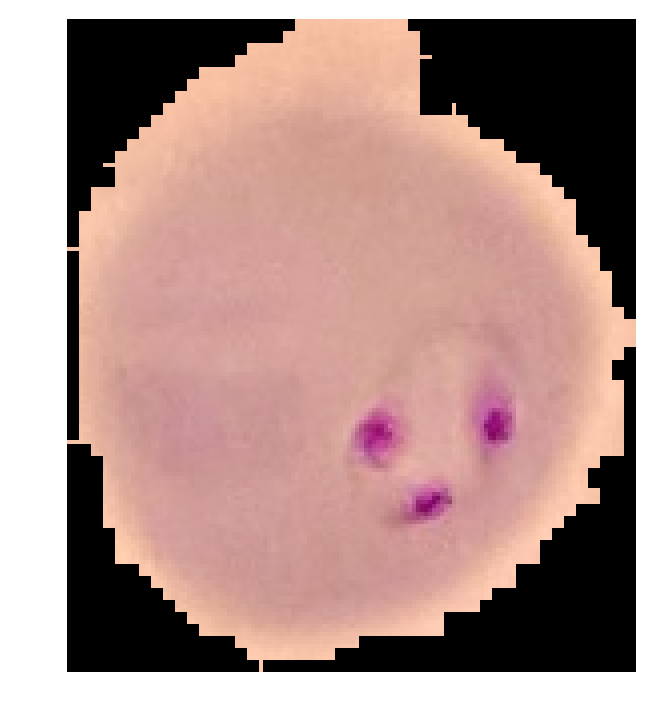

In [21]:
img_dir='/content/drive/My Drive/cell_images'
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
# Example image
x = Image.open(img_dir + '/Parasitized/C33P1thinF_IMG_20150619_114756a_cell_179.png')
np.array(x).shape
imshow(x)

Defining Transformations and Loading in Data
Transformation is a process by which one figure, expression, or function is converted into another. Now let’s define a few transformations for the training, testing, & validation data. We should keep in mind that in some categories, there could be a limited number of images. Thus in order to increase the number of images recognized by the network, we perform what is called data augmentation.

During training, we randomly crop, resize, and rotate the images so that for each epoch (one pass through the dataset), the network sees different variations of the same image.This will eventually lead to better accuracy on your validation tests. Note that with validation data, we don’t perform data augmentation but just do a resize & centre crop. This is because we want our validation data to be similar or look like your eventual input data (out of sample data/test data).

In [0]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                      transforms.RandomRotation(degrees=15),
                                      transforms.ColorJitter(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.CenterCrop(size=224),  # Image net standards
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                      ])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])


With the transformations defined, we have to load in the dataset and easiest way to load image data is by using the dataset.ImageFolder from torchvision which accepts as input the path to the images and transforms.

With the imageFolder loaded, let’s split the data into a 20% validation set and 10% test set; then pass it to DataLoader, which takes a dataset like you’d get from ImageFolder and returns batches of images and their corresponding labels (shuffling can be set to true to introduce variation during the epochs).

In [0]:
#Loading in the dataset
train_data = datasets.ImageFolder(img_dir,transform=train_transforms)
# number of subprocesses to use for data loading
num_workers = 0
# percentage of training set to use as validation
valid_size = 0.2

test_size = 0.1

In [24]:
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_split = int(np.floor((valid_size) * num_train))
test_split = int(np.floor((valid_size+test_size) * num_train))
valid_idx, test_idx, train_idx = indices[:valid_split], indices[valid_split:test_split], indices[test_split:]

print(len(valid_idx), len(test_idx), len(train_idx))


5511 2756 19291


In [0]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [0]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=32, 
    sampler=test_sampler, num_workers=num_workers)

# Steps for Training the model

The steps we are going to use for our pre-trained model is:

1) Loading in the pre-trained model
2) Freezing the convolutional layers
3) Replacing the fully connected layers with a custom classifier
4) Training the custom classifier for the specific task

We can now load in one of the pre-trained models, here I’m going to use the densenet121, which has high accuracy on the ImageNet dataset. This is telling us there are 121 different layers.

In [27]:
# Loading the Pre-trained Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#pretrained=True will download a pretrained network for us
model = models.densenet121(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:01<00:00, 28478024.71it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

With our model built, we need to train the classifier. However, now we’re using a really deep neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we’re going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU, leading to 100x increased training speeds. It’s also possible to train on multiple GPUs, further decreasing training time.

PyTorch, along with pretty much every other deep learning framework, uses CUDA to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using model.cuda(). You can move them back from the GPU with model.cpu(), which you'll commonly do when you need to operate on the network output outside of PyTorch.

In [28]:
#Freezing model parameters and defining the fully connected network to be attached to the model, loss function and the optimizer.
#We there after put the model on the GPUs
for param in model.parameters():
  param.require_grad = False
fc = nn.Sequential(
    nn.Linear(1024, 460),
    nn.ReLU(),
    nn.Dropout(0.4),
    
    nn.Linear(460,2),
    nn.LogSoftmax(dim=1))

model.classifier = fc
criterion = nn.NLLLoss()
#Over here we want to only update the parameters of the classifier so
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.003)
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

Freezing the model parameters essentially allows us to keep the pre-trained model’s weights for early convolutional layers — whose purpose is for feature extraction. We then define our fully-connected network, which will have as input neurons, 1024 (this depends on the pre-trained model’s input neurons) and a custom hidden layer.

We also define the activation function to be used and a dropout that will aid in avoiding overfitting by randomly switching off neurons in a layer to force information to be shared among the remaining nodes.

After we have defined our custom fully-connected network, we attach it to the pre-trained model’s fully-connected network to suit the problem we want to solve. We finally define the loss function, the optimizer, and prepare the model for training by moving it to the GPUs.

# Training the custom classifier for the specific task

During the training, we iterate through the DataLoader for each epoch. For each batch, the loss is calculated using the criterion function. The gradients of the loss with respect to the model parameters is calculated using the loss.backward() method.

The optimizer.zero_grad() is responsible for clearing any accumulated gradients since we would be calculating gradients over and over again. optimizer.step() updates the model parameters using Stochastic Gradient Descent with momentum (Adam).

To prevent overfitting we use a powerful technique called early stopping. The idea behind is simple—to stop training when the performance on the validation dataset begin to degrade.

In [47]:
#Training the model and saving checkpoints of best performances. That is lower validation loss and higher accuracy
epochs = 10
valid_loss_min = np.Inf
import time
for epoch in range(epochs):
    
    start = time.time()
    
    #scheduler.step()
    model.train()
    
    train_loss = 0.0
    valid_loss = 0.0
    
    for inputs, labels in train_loader:
        
       
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
train_loss += loss.item()
        
model.eval()
    
with torch.no_grad():
  accuracy = 0
  for inputs, labels in valid_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    logps = model.forward(inputs)
    batch_loss = criterion(logps, labels)
valid_loss += batch_loss.item()

# Calculate accuracy
ps = torch.exp(logps)
top_p, top_class = ps.topk(1, dim=1)
equals = top_class == labels.view(*top_class.shape)
accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            
            
# calculate average losses
train_loss = train_loss/len(train_loader)
valid_loss = valid_loss/len(valid_loader)
valid_accuracy = accuracy/len(valid_loader) 
      
# print training/validation statistics 
print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
    epoch + 1, train_loss, valid_loss, valid_accuracy))
            
if valid_loss <= valid_loss_min:
  print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_loss_min,
      valid_loss))
  model_save_name = "Malaria.pt"
  path = F"/content/drive/My Drive/{model_save_name}"
torch.save(model.state_dict(), path)
valid_loss_min = valid_loss

print(f"Time per epoch: {(time.time() - start):.3f} seconds")


Epoch: 10 	Training Loss: 0.000597 	Validation Loss: 0.001015 	Validation Accuracy: 0.004955
Validation loss decreased (inf --> 0.001015).  Saving model ...
Time per epoch: 235.421 seconds


After patiently waiting for the training process to finish and saving checkpoints of best model parameters, let’s load the checkpoint and test the performance of the model on the unseen data (test data).

# Loading the saved model from disk

model.load_state_dict(torch.load('Malaria.pt'))

Testing loaded model on unseen data. We have an accuracy of 90% on unseen data which is very impressive on a first attempt.

In [48]:
def test(model, criterion):
  # monitor test loss and accuracy
  test_loss = 0.0
  correct = 0.0
  total = 0.0
for batch_idx, (data, target) in enumerate(test_loader):
  # move to GPU
  if torch.cuda.is_available():
    data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update average test loss 
    test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
    # convert output probabilities to predicted class
    pred = output.data.max(1, keepdim=True)[1]
    # compare predictions to true label
    correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
    total += data.size(0)
            
print('Test Loss: {:.6f}\n'.format(test_loss))
print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
test(model, criterion)

NameError: ignored

Now that we have confidence in our model, it’s time to make some predictions and visualize the results.

In [0]:
def load_input_image(img_path):    
    image = Image.open(img_path)
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image


In [0]:
def predict_malaria(model, class_names, img_path):
    # load the image and return the predicted breed
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

In [0]:
from glob import glob
from PIL import Image
from termcolor import colored

class_names=['Parasitized','Uninfected']
inf = np.array(glob(img_dir + "/Parasitized/*"))
uninf = np.array(glob(img_dir + "/Uninfected/*"))
for i in range(3):
    img_path=inf[i]
    img = Image.open(img_path)
    if predict_malaria(model, class_names, img_path) == 'Parasitized':
        print(colored('Parasitized', 'green'))
    else:
        print(colored('Uninfected', 'red'))
    plt.imshow(img)
    plt.show()
for i in range(3):
    img_path=uninf[i]
    img = Image.open(img_path)
    if predict_malaria(model, class_names, img_path) == 'Uninfected':
        print(colored('Uninfected', 'green'))
    else:
        print(colored('Parasitized', 'red'))        
    plt.imshow(img)
    plt.show()

Go ahead and play around with the code, and see how you can improve on the test accuracy. Try making changes to the optimizer, the pre-trained model and the loss function. You can add more transformations or even add more layers to the fully connected. I believe you can surpass the 90% benchmark. Cheers!